✅ Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU
📁 Classes: ['jafar', 'karthik', 'unknown', 'vishwanath']

🚀 Epoch 1/10


TRAIN: 100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Train | Loss: 1.3101 | Acc: 0.378


VAL: 100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


Val | Loss: 1.0632 | Acc: 0.871
💾 Best model saved (val_acc=0.871)

🚀 Epoch 2/10


TRAIN: 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


Train | Loss: 0.8809 | Acc: 0.739


VAL: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Val | Loss: 0.5738 | Acc: 0.965
💾 Best model saved (val_acc=0.965)

🚀 Epoch 3/10


TRAIN: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]


Train | Loss: 0.6649 | Acc: 0.874


VAL: 100%|██████████| 11/11 [00:04<00:00,  2.22it/s]


Val | Loss: 0.4736 | Acc: 0.965

🚀 Epoch 4/10


TRAIN: 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]


Train | Loss: 0.6129 | Acc: 0.905


VAL: 100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


Val | Loss: 0.4280 | Acc: 0.976
💾 Best model saved (val_acc=0.976)

🚀 Epoch 5/10


TRAIN: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]


Train | Loss: 0.5555 | Acc: 0.910


VAL: 100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Val | Loss: 0.4229 | Acc: 0.988
💾 Best model saved (val_acc=0.988)

🚀 Epoch 6/10


TRAIN: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Train | Loss: 0.5238 | Acc: 0.937


VAL: 100%|██████████| 11/11 [00:02<00:00,  3.93it/s]


Val | Loss: 0.4140 | Acc: 0.965

🚀 Epoch 7/10


TRAIN: 100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Train | Loss: 0.5206 | Acc: 0.941


VAL: 100%|██████████| 11/11 [00:02<00:00,  4.75it/s]


Val | Loss: 0.4117 | Acc: 0.976

🚀 Epoch 8/10


TRAIN: 100%|██████████| 28/28 [00:07<00:00,  3.66it/s]


Train | Loss: 0.4920 | Acc: 0.950


VAL: 100%|██████████| 11/11 [00:01<00:00,  5.52it/s]


Val | Loss: 0.4083 | Acc: 0.988
⏸️ Early stopping triggered.

✅ Best Validation Accuracy: 0.988


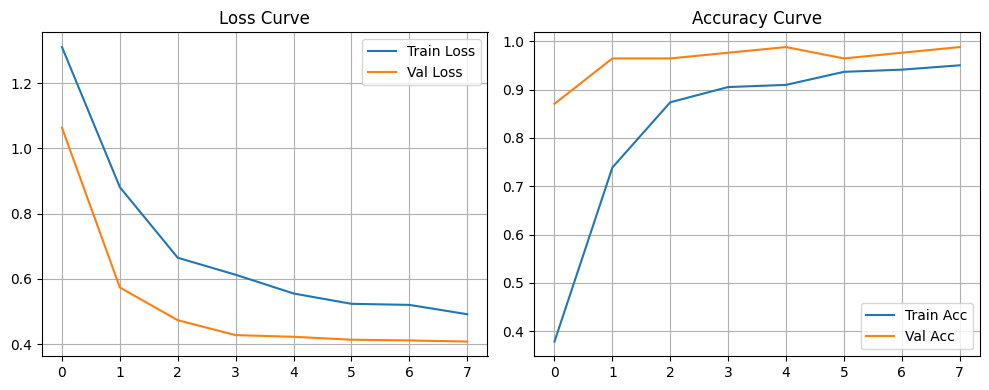

In [16]:
# ==============================================================
# ⚡ EfficientNet-B0 Fine-Tuning (Small Dataset Optimized)
# ==============================================================

import os, copy, random, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

train_dir = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\train"
val_dir   = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\val"
save_dir  = r"C:\Users\vishw\OneDrive\Desktop\deep_learning"
save_path = os.path.join(save_dir, "best_effnetb0_fixed.pth")

# ---------------- AUGMENTATIONS ----------------
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05), scale=(0.9,1.1)),
    transforms.RandomResizedCrop(224, scale=(0.85,1.0)),
    transforms.RandomGrayscale(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# ---------------- DATA ----------------
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir, transform=val_tfms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0)
class_names = train_ds.classes
num_classes = len(class_names)
print("📁 Classes:", class_names)

# ---------------- MODEL ----------------
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Unfreeze last two blocks for fine-tuning
for name, param in model.named_parameters():
    param.requires_grad = any(f"features.{i}" in name for i in [6,7])

# Replace classifier
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# ---------------- TRAIN SETUP ----------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# ---------------- TRAIN FUNCTION ----------------
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    best_acc, patience_counter = 0.0, 0
    best_model_wts = copy.deepcopy(model.state_dict())
    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            dataloader = train_loader if phase == "train" else val_loader

            running_loss, running_corrects, total = 0.0, 0, 0
            for imgs, labels in tqdm(dataloader, desc=phase.upper()):
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase=="train":
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        optimizer.step()

                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total
            hist[f"{phase}_loss"].append(epoch_loss)
            hist[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase.capitalize()} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.3f}")

            if phase == "val":
                scheduler.step()
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_path)
                    print(f"💾 Best model saved (val_acc={best_acc:.3f})")
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("⏸️ Early stopping triggered.")
            break

    print(f"\n✅ Best Validation Accuracy: {best_acc:.3f}")
    model.load_state_dict(best_model_wts)
    return model, hist

# ---------------- TRAIN ----------------
model, hist = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

# ---------------- PLOT ----------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["train_loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(hist["train_acc"], label="Train Acc")
plt.plot(hist["val_acc"], label="Val Acc")
plt.title("Accuracy Curve"); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()


🔄 Loading model...


C:\Users\vishw\AppData\Local\Temp\ipykernel_18032\315534249.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)


✅ Model loaded successfully on cuda
🎯 Prediction: vishwanath (80.61%)

✅ Result → vishwanath (80.61%)


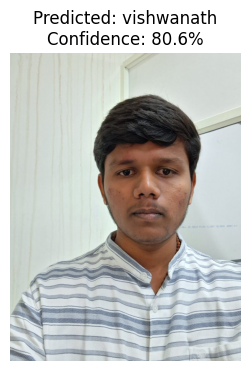

In [6]:
# ================================================================
# 🧠 EfficientNet-B0 Test Script (Display + Prediction)
# ================================================================
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def test_with_display(image_path):
    # ---------------- CONFIG ----------------
    MODEL_PATH = r"C:\Users\vishw\OneDrive\Desktop\Face_identification\best_effnetb0_fixed.pth"
    CLASS_NAMES = ["jafar", "karthik", "unknown", "vishwanath"]  # same order as training
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------------- MODEL LOADING ----------------
    print("🔄 Loading model...")
    model = models.efficientnet_b0(weights=None)
    in_features = model.classifier[1].in_features
    model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features, 512),
        torch.nn.BatchNorm1d(512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, len(CLASS_NAMES))
    )

    # Load checkpoint (handle plain or dict)
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    else:
        model.load_state_dict(checkpoint, strict=False)

    model.to(DEVICE).eval()
    print("✅ Model loaded successfully on", DEVICE)

    # ---------------- TRANSFORM ----------------
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # ---------------- IMAGE LOADING ----------------
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"❌ Image not found: {image_path}")

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    # ---------------- PREDICTION ----------------
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        pred_idx = np.argmax(probabilities)
        confidence = probabilities[pred_idx]
        predicted_class = CLASS_NAMES[pred_idx]

    # ---------------- DISPLAY ----------------
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence*100:.1f}%")


    print(f"🎯 Prediction: {predicted_class} ({confidence*100:.2f}%)")
    return predicted_class, confidence


# ---------------- RUN ----------------
if __name__ == "__main__":
    img_path = r"C:\Users\vishw\Downloads\WhatsApp Image 2025-11-07 at 10.38.29_8802af12.jpg"
    pred_class, conf = test_with_display(img_path)
    print(f"\n✅ Result → {pred_class} ({conf*100:.2f}%)")
